In [1]:
imgsize = 128
seeds = 0

In [2]:
import numpy as np
import math
import time
import scipy.io
import scipy.optimize
import matplotlib.pyplot
import six.moves.cPickle as pickle
import gzip
import os
import sys
from sklearn.preprocessing import MinMaxScaler

###########################################################################################
""" The Sparse Autoencoder class """

class SparseAutoencoder(object):

    #######################################################################################
    """ Initialization of Autoencoder object """

    def __init__(self, visible_size, hidden_size, rho, lamda, beta):
    
        """ Initialize parameters of the Autoencoder object """
    
        self.visible_size = visible_size    # number of input units
        self.hidden_size = hidden_size      # number of hidden units
        self.rho = rho                      # desired average activation of hidden units
        self.lamda = lamda                  # weight decay parameter
        self.beta = beta                    # weight of sparsity penalty term
        
        """ Set limits for accessing 'theta' values """
        
        self.limit0 = 0
        self.limit1 = hidden_size * visible_size
        self.limit2 = 2 * hidden_size * visible_size
        self.limit3 = 2 * hidden_size * visible_size + hidden_size
        self.limit4 = 2 * hidden_size * visible_size + hidden_size + visible_size
        
        """ Initialize Neural Network weights randomly
            W1, W2 values are chosen in the range [-r, r] """
        
        r = math.sqrt(6) / math.sqrt(visible_size + hidden_size + 1)
        
        rand = np.random.RandomState(int(time.time()))
        
        W1 = np.asarray(rand.uniform(low = -r, high = r, size = (hidden_size, visible_size)))
        W2 = np.asarray(rand.uniform(low = -r, high = r, size = (visible_size, hidden_size)))
        
        """ Bias values are initialized to zero """
        
        b1 = np.zeros((hidden_size, 1))
        b2 = np.zeros((visible_size, 1))

        """ Create 'theta' by unrolling W1, W2, b1, b2 """

        self.theta = np.concatenate((W1.flatten(), W2.flatten(),
                                        b1.flatten(), b2.flatten()))

    #######################################################################################
    """ Returns elementwise sigmoid output of input array """
    
    def sigmoid(self, x):
    
        return (1 / (1 + np.exp(-x)))

    #######################################################################################
    """ Returns the cost of the Autoencoder and gradient at a particular 'theta' """
        
    def sparseAutoencoderCost(self, theta, input):
        
        """ Extract weights and biases from 'theta' input """
        
        W1 = theta[self.limit0 : self.limit1].reshape(self.hidden_size, self.visible_size)
        W2 = theta[self.limit1 : self.limit2].reshape(self.visible_size, self.hidden_size)
        b1 = theta[self.limit2 : self.limit3].reshape(self.hidden_size, 1)
        b2 = theta[self.limit3 : self.limit4].reshape(self.visible_size, 1)
        
        """ Compute output layers by performing a feedforward pass
            Computation is done for all the training inputs simultaneously """
        
        hidden_layer = self.sigmoid(np.dot(W1, input) + b1)
        output_layer = self.sigmoid(np.dot(W2, hidden_layer) + b2)
        
        """ Estimate the average activation value of the hidden layers """
        
        rho_cap = np.sum(hidden_layer, axis = 1) / input.shape[1]
        
        """ Compute intermediate difference values using Backpropagation algorithm """
        
        diff = output_layer - input
        
        sum_of_squares_error = 0.5 * np.sum(np.multiply(diff, diff)) / input.shape[1]
        weight_decay         = 0.5 * self.lamda * (np.sum(np.multiply(W1, W1)) +
                                                   np.sum(np.multiply(W2, W2)))
        KL_divergence        = self.beta * np.sum(self.rho * np.log(self.rho / rho_cap) +
                                                    (1 - self.rho) * np.log((1 - self.rho) / (1 - rho_cap)))
        cost                 = sum_of_squares_error + weight_decay + KL_divergence
        
        KL_div_grad = self.beta * (-(self.rho / rho_cap) + ((1 - self.rho) / (1 - rho_cap)))
        
        del_out = np.multiply(diff, np.multiply(output_layer, 1 - output_layer))
        del_hid = np.multiply(np.dot(np.transpose(W2), del_out) + np.transpose(np.matrix(KL_div_grad)), 
                                 np.multiply(hidden_layer, 1 - hidden_layer))
        
        """ Compute the gradient values by averaging partial derivatives
            Partial derivatives are averaged over all training examples """
            
        W1_grad = np.dot(del_hid, np.transpose(input))
        W2_grad = np.dot(del_out, np.transpose(hidden_layer))
        b1_grad = np.sum(del_hid, axis = 1)
        b2_grad = np.sum(del_out, axis = 1)
            
        W1_grad = W1_grad / input.shape[1] + self.lamda * W1
        W2_grad = W2_grad / input.shape[1] + self.lamda * W2
        b1_grad = b1_grad / input.shape[1]
        b2_grad = b2_grad / input.shape[1]
        
        """ Transform numpy matrices into arrays """
        
        W1_grad = np.array(W1_grad)
        W2_grad = np.array(W2_grad)
        b1_grad = np.array(b1_grad)
        b2_grad = np.array(b2_grad)
        
        """ Unroll the gradient values and return as 'theta' gradient """
        
        theta_grad = np.concatenate((W1_grad.flatten(), W2_grad.flatten(),
                                        b1_grad.flatten(), b2_grad.flatten()))
                                        
        return [cost, theta_grad]


""" Visualizes the obtained optimal W1 values as images """

def visualizeW1(opt_W1, vis_patch_side, hid_patch_side):

    """ Add the weights as a matrix of images """
    
    figure, axes = matplotlib.pyplot.subplots(nrows = hid_patch_side,
                                              ncols = hid_patch_side)
    index = 0
                                              
    for axis in axes.flat:
    
        """ Add row of weights as an image to the plot """
    
        image = axis.imshow(opt_W1[index, :].reshape(vis_patch_side, vis_patch_side),
                            cmap = matplotlib.pyplot.cm.gray, interpolation = 'nearest')
        axis.set_frame_on(False)
        axis.set_axis_off()
        index += 1
        
    """ Show the obtained plot """  
        
    matplotlib.pyplot.show()


def executeSparseAutoencoder(training_data):

    """ Define the parameters of the Autoencoder """
    
    vis_patch_side = imgsize      # side length of sampled image patches
    hid_patch_side = 40     # side length of representative image patches
    rho            = 0.01   # desired average activation of hidden units
    lamda          = 0.0001 # weight decay parameter
    beta           = 3      # weight of sparsity penalty term
    num_patches    = training_data.shape[-1]  # number of training examples
    max_iterations = 500   # number of optimization iterations

    visible_size = vis_patch_side * vis_patch_side  # number of input units
    hidden_size  = hid_patch_side * hid_patch_side  # number of hidden units
    
   
    
    """ Initialize the Autoencoder with the above parameters """
    
    encoder = SparseAutoencoder(visible_size, hidden_size, rho, lamda, beta)
    
    """ Run the L-BFGS algorithm to get the optimal parameter values """
    
    opt_solution  = scipy.optimize.minimize(encoder.sparseAutoencoderCost, encoder.theta, 
                                            args = (training_data,), method = 'L-BFGS-B', 
                                            jac = True, options = {'maxiter': max_iterations,'disp': True})
    opt_theta = opt_solution.x
    opt_W1 = opt_theta[encoder.limit0 : encoder.limit1].reshape(hidden_size, visible_size)
    opt_W2 = opt_theta[encoder.limit1 : encoder.limit2].reshape(visible_size, hidden_size)
    opt_b1 = opt_theta[encoder.limit2 : encoder.limit3].reshape(hidden_size, 1)
    opt_b2 = opt_theta[encoder.limit3 : encoder.limit4].reshape(visible_size, 1)
    """ Visualize the obtained optimal W1 weights """
    compressedInputs= encoder.sigmoid(numpy.dot(opt_W1, training_data) + opt_b1)
    visualizeW1(opt_W1, vis_patch_side, hid_patch_side)
    return opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs

def executeMain(training_data):
    opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs=executeSparseAutoencoder(training_data)
    return opt_W1,opt_W2,opt_b1,opt_b2,np.transpose(compressedInputs)

In [3]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

In [4]:
from __future__ import print_function
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from six.moves import urllib

torch.manual_seed(seeds)
plt.ion()  
import tensorflow
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import os
from sklearn.svm import SVC
import scipy.linalg as la
from numpy.random import seed
import gurobipy as gp
from gurobipy import GRB
from sklearn.model_selection import train_test_split
seed(seeds)
tensorflow.random.set_seed(seeds)


2022-10-17 00:50:09.813097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 00:50:09.969082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 00:50:09.969111: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-17 00:50:09.997537: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 00:50:10.553298: W tensorflow/stream_executor/pla

In [5]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

full_dataset = torchvision.datasets.ImageFolder(root = '/data/siddhant/MedicalSTN/DrVineetData/Knee_Full_AP', 
                                     transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Grayscale(num_output_channels=1),
                       transforms.Resize((imgsize,imgsize)),
                   ]))

X, y = torch.vstack([full_dataset[i][0].unsqueeze(0) for i in range(len(full_dataset))]), torch.tensor(full_dataset.targets)
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state = seeds)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=seeds) # 0.25 x 0.8 = 0.2
Xtrainshape = X_train.shape
Xvalshape = X_val.shape
Xtestshape = X_test.shape
X_train = X_train.reshape(Xtrainshape[0],-1)
X_val = X_val.reshape(Xvalshape[0],-1)
X_test = X_test.reshape(Xtestshape[0],-1)



(447,) (447, 16384)
(447, 16384)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     52446784     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  3.85067D+03    |proj g|=  2.37395D+00

At iterate    1    f=  1.91091D+03    |proj g|=  1.35945D+00

At iterate    2    f=  1.08097D+03    |proj g|=  3.40127D-01

At iterate    3    f=  8.53295D+02    |proj g|=  1.86147D-01

At iterate    4    f=  7.41103D+02    |proj g|=  8.98178D-02

At iterate    5    f=  6.98643D+02    |proj g|=  8.87537D-02

At iterate    6    f=  6.83760D+02    |proj g|=  8.81541D-02

At iterate    7    f=  6.79242D+02    |proj g|=  8.78658D-02

At iterate    8    f=  6.76802D+02    |proj g|=  8.76160D-02

At iterate    9    f=  6.72485D+02    |proj g|=  8.70245D-02

At iterate   10    f=  6.61869D+02    |proj g|=  8.53793D-02

At iterate   11    f=  6.35666D+02    |proj g|=  8.08952D-02

At iterate   12    f=  5.72622D+02    |proj g|=  6.83639D-02

At iterate   13    f=  4.54796D+02    |proj g|=  1.83049D-01

At iterate   14    f=  4.33299D+02    |proj g|=  6.94102D-02

At iterate   15    f=  3.75236D+02    |proj g|=  1.38800D+00

At iter


At iterate  133    f=  1.15146D+02    |proj g|=  2.55520D-02

At iterate  134    f=  1.14863D+02    |proj g|=  4.27932D-02

At iterate  135    f=  1.13168D+02    |proj g|=  6.69615D-02

At iterate  136    f=  1.12591D+02    |proj g|=  2.23514D-02

At iterate  137    f=  1.11897D+02    |proj g|=  5.27109D-02

At iterate  138    f=  1.11082D+02    |proj g|=  4.02598D-02

At iterate  139    f=  1.10215D+02    |proj g|=  2.58309D-02

At iterate  140    f=  1.09413D+02    |proj g|=  7.79721D-02

At iterate  141    f=  1.08660D+02    |proj g|=  2.01485D-02

At iterate  142    f=  1.07977D+02    |proj g|=  2.10687D-02

At iterate  143    f=  1.07083D+02    |proj g|=  3.13518D-02

At iterate  144    f=  1.05955D+02    |proj g|=  2.11741D-02

At iterate  145    f=  1.05151D+02    |proj g|=  3.29299D-02

At iterate  146    f=  1.04229D+02    |proj g|=  2.46218D-02

At iterate  147    f=  1.03679D+02    |proj g|=  4.16371D-02

At iterate  148    f=  1.02800D+02    |proj g|=  2.45508D-02

At iter


At iterate  266    f=  6.34869D+01    |proj g|=  7.32757D-02

At iterate  267    f=  6.33221D+01    |proj g|=  1.71384D-02

At iterate  268    f=  6.32224D+01    |proj g|=  1.35262D-02

At iterate  269    f=  6.29586D+01    |proj g|=  3.59096D-02

At iterate  270    f=  6.27989D+01    |proj g|=  2.25929D-02

At iterate  271    f=  6.25841D+01    |proj g|=  1.68354D-02

At iterate  272    f=  6.24086D+01    |proj g|=  1.48158D-02

At iterate  273    f=  6.21603D+01    |proj g|=  2.12988D-02

At iterate  274    f=  6.19576D+01    |proj g|=  5.15603D-02

At iterate  275    f=  6.18390D+01    |proj g|=  1.81002D-02

At iterate  276    f=  6.17704D+01    |proj g|=  1.46316D-02

At iterate  277    f=  6.15673D+01    |proj g|=  2.18254D-02

At iterate  278    f=  6.13925D+01    |proj g|=  2.80706D-02

At iterate  279    f=  6.12609D+01    |proj g|=  4.55096D-02

At iterate  280    f=  6.10497D+01    |proj g|=  2.11580D-02

At iterate  281    f=  6.08642D+01    |proj g|=  3.01755D-02

At iter


At iterate  399    f=  4.81357D+01    |proj g|=  1.89298D-02

At iterate  400    f=  4.80573D+01    |proj g|=  1.36806D-02

At iterate  401    f=  4.79669D+01    |proj g|=  1.04200D-02

At iterate  402    f=  4.78750D+01    |proj g|=  1.65617D-02

At iterate  403    f=  4.77734D+01    |proj g|=  1.80858D-02

At iterate  404    f=  4.76756D+01    |proj g|=  1.91547D-02

At iterate  405    f=  4.75541D+01    |proj g|=  2.62544D-02

At iterate  406    f=  4.74985D+01    |proj g|=  2.33041D-02

At iterate  407    f=  4.74521D+01    |proj g|=  2.18195D-02

At iterate  408    f=  4.73476D+01    |proj g|=  1.13434D-02

At iterate  409    f=  4.72513D+01    |proj g|=  1.50898D-02

At iterate  410    f=  4.71512D+01    |proj g|=  2.08497D-02

At iterate  411    f=  4.70449D+01    |proj g|=  1.22139D-02

At iterate  412    f=  4.69551D+01    |proj g|=  1.02323D-02

At iterate  413    f=  4.68718D+01    |proj g|=  1.64147D-02

At iterate  414    f=  4.67810D+01    |proj g|=  1.40674D-02

At iter

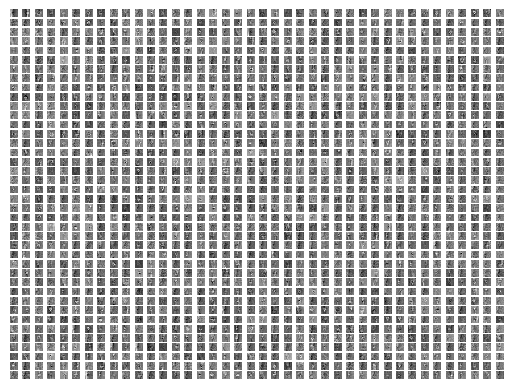

"n_models=n_classes\nminibatch_size = 100\nn_hidden=100\nn_planes=4\nn_iter = 600\nlr=0.005\nprint(n_classes)\nmodel=[]\nfor k in range(n_models):\n    # create models\n    #odel[k] = make_network(n_hidden,n_planes,n_feature)\n    model.append(make_network(n_hidden,n_planes,n_feature))\n\n\nmodel = sgd(model, X_train, y_train, minibatch_size,n_planes,n_models,n_hidden,n_iter,X_Val,y_Val,X_test,y_test,n_classes,lr)\n\n\ny_pred = np.zeros_like(y_test)\n\nfor i, x in enumerate(X_test):\n    y = np.ones((n_models,))\n    for index, indmodel in enumerate(model, start=0): \n        oop,iop,hop = forward(x, indmodel)\n        val=(np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))\n        y[index]= ((np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))).min()\n    \n    y_pred[i] = y.argmin()\n\n# Compare the predictions with the true labels and take the percentage\naccs= (y_pred == y_test).sum() / y_test.size\n\n\ncnf_matrix = confusion_matrix(y_test, y_pred)\n#print(cnf_matrix)\nplt.figure()

In [6]:
###### eigenbag ###########
from itertools import combinations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy.matlib
from sklearn.metrics import f1_score
import six.moves.cPickle as pickle
import gzip
import os



# with gzip.open('mnist.pkl.gz', 'rb') as f:
#     try:
#         train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
#     except:
#         train_set, valid_set, test_set = pickle.load(f)
# X_train, y_train = train_set
# X_test, y_test = test_set
# X_Val, y_Val = valid_set  
print(y_train.shape, X_train.shape)
scaler = MinMaxScaler(copy=True, feature_range=(0.1, 0.9))
scaler.fit(X_train)
dataset=scaler.transform(X_train)
print(dataset.shape)

opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs=executeMain(np.transpose(dataset))


        
'''n_models=n_classes
minibatch_size = 100
n_hidden=100
n_planes=4
n_iter = 600
lr=0.005
print(n_classes)
model=[]
for k in range(n_models):
    # create models
    #odel[k] = make_network(n_hidden,n_planes,n_feature)
    model.append(make_network(n_hidden,n_planes,n_feature))


model = sgd(model, X_train, y_train, minibatch_size,n_planes,n_models,n_hidden,n_iter,X_Val,y_Val,X_test,y_test,n_classes,lr)


y_pred = np.zeros_like(y_test)

for i, x in enumerate(X_test):
    y = np.ones((n_models,))
    for index, indmodel in enumerate(model, start=0): 
        oop,iop,hop = forward(x, indmodel)
        val=(np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))
        y[index]= ((np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))).min()
    
    y_pred[i] = y.argmin()

# Compare the predictions with the true labels and take the percentage
accs= (y_pred == y_test).sum() / y_test.size


cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
plt.figure()
plot_confusion_matrix(cnf_matrix,n_classes, normalize=False,
                      title='confusion matrix')

plt.show()
print('Test  accuracy: {}'.format(accs))'''

In [7]:
from itertools import combinations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy.matlib
from sklearn.metrics import f1_score
import six.moves.cPickle as pickle
import gzip
import os

n_feature=dataset.shape[1]
# print(type(y_train))
if np.min(y_train)==0:
    n_classes=int(np.max(y_train)+1)
else:
    n_classes=int(np.max(y_train))
    y_train=y_train-1
    y_test=y_test-1
    y_Val=y_Val-1

print(opt_b1.shape)



runs=20
fra=0.8
sizeFraction=50
comFactor=50
genDataTrainXFinalClassInc = np.empty(shape=[0, compressedInputs.shape[1]])
genDataTrainYFinalClassInc=np.empty(shape=[0,])
for cl in tqdm(range(n_classes)):
    genDataTrainXFinal = np.empty(shape=[0, compressedInputs.shape[1]])
    data_train=compressedInputs[y_train==cl,:] #select classwise data
    for ru in tqdm(range(runs)):
        #select 40 samples randomly 
        ranNums=np.random.randint(low=0, high=data_train.shape[0], size=sizeFraction)
        data_train_used=data_train[ranNums,:]
        LP = range(data_train_used.shape[0])
    
        combP = combinations(LP, comFactor)
        #print(len(list(combP)))
        genDataTrainX = np.empty(shape=[0, data_train.shape[1]])
        for j in list(combP): 
            #print(np.asarray(j))
            X=data_train_used[np.asarray(j),:]
           
            numClust=10
            kms=KMeans(n_clusters=numClust)
            kms.fit(X)
            y_pred = kms.predict(X)
            clus=kms.cluster_centers_
            #print(y_pred)
            genData = np.empty(shape=[0, X.shape[1]])
            for k in (range(numClust)):
                tempData=X[y_pred==k,:]
                #print(tempData.shape)
                newData=fra*tempData +(1-fra)*np.matlib.repmat(clus[k,:], tempData.shape[0], 1)
                genData = np.append(genData, newData, axis=0)
        
            #print('.')
            predictedGenClass=cl*np.ones([genData.shape[0],])
            #project back
            #genDataHigh=pca.inverse_transform(genData)
            #print(genDataHigh.shape)
            genDataTrainX=np.append(genDataTrainX,genData,axis=0)
        
    
        genDataTrainXFinal=np.append(genDataTrainXFinal,genDataTrainX,axis=0) 
        #print(ru)
    genDataTrainYFinalClassInc=np.append(genDataTrainYFinalClassInc,cl*np.ones((genDataTrainXFinal.shape[0],)),axis=0) 
    genDataTrainXFinalClassInc=np.append(genDataTrainXFinalClassInc,genDataTrainXFinal,axis=0) 
    print(cl)
print(genDataTrainXFinalClassInc.shape)
print(genDataTrainYFinalClassInc.shape)

#project back
highDimGen=np.transpose(sigmoid(np.dot(opt_W2, np.transpose(genDataTrainXFinalClassInc)) + opt_b2))

highDimGen=scaler.inverse_transform(highDimGen)

#visualizeW1(highDimGen[2000:2028,:], 28, 28)
X_train1=np.append(X_train,highDimGen,axis=0) 
y_train1 = np.append(y_train,genDataTrainYFinalClassInc,axis=0)
print(X_train1.shape)
print(y_train1.shape)



(1600, 1)


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0


  0%|          | 0/20 [00:00<?, ?it/s]

1


  0%|          | 0/20 [00:00<?, ?it/s]

2


  0%|          | 0/20 [00:00<?, ?it/s]

3


  0%|          | 0/20 [00:00<?, ?it/s]

4


  0%|          | 0/20 [00:00<?, ?it/s]

5


  0%|          | 0/20 [00:00<?, ?it/s]

6


  0%|          | 0/20 [00:00<?, ?it/s]

7


  0%|          | 0/20 [00:00<?, ?it/s]

8


  0%|          | 0/20 [00:00<?, ?it/s]

9


  0%|          | 0/20 [00:00<?, ?it/s]

10


  0%|          | 0/20 [00:00<?, ?it/s]

11


  0%|          | 0/20 [00:00<?, ?it/s]

12


  0%|          | 0/20 [00:00<?, ?it/s]

13


  0%|          | 0/20 [00:00<?, ?it/s]

14


  0%|          | 0/20 [00:00<?, ?it/s]

15


  0%|          | 0/20 [00:00<?, ?it/s]

16


  0%|          | 0/20 [00:00<?, ?it/s]

17


  0%|          | 0/20 [00:00<?, ?it/s]

18


  0%|          | 0/20 [00:00<?, ?it/s]

19


  0%|          | 0/20 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

21


  0%|          | 0/20 [00:00<?, ?it/s]

22


  0%|          | 0/20 [00:00<?, ?it/s]

23


  0%|          | 0/20 [00:00<?, ?it/s]

24


  0%|          | 0/20 [00:00<?, ?it/s]

25


  0%|          | 0/20 [00:00<?, ?it/s]

26


  0%|          | 0/20 [00:00<?, ?it/s]

27
(28000, 1600)
(28000,)
(28447, 16384)
(28447,)


In [8]:
import six.moves.cPickle as pickle
from sklearn.utils import shuffle

# X_test, y_test = test_set
# X_Val, y_Val = valid_set  
X_train1, y_train1 = shuffle(X_train1, y_train1)
scaler1 = MinMaxScaler(copy=True, feature_range=(-0.9, 0.9))
scaler.fit(X_train1)
X_train1=scaler.transform(X_train1)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [9]:
X_train1=X_train1.reshape(-1,*Xtrainshape[1:])
X_val=X_val.reshape(Xvalshape)
X_test=X_test.reshape(Xtestshape)

In [10]:
print(X_train1.shape)
# Total_data = np.array([X_train1, y_train1,X_val,y_val,X_test,y_test])
# np.save(f'Knee_{imgsize}_{X_train1.shape[0]}', Total_data)
with open(f'EigenData/Knee_{imgsize}_{X_train1.shape[0]}.bin', 'wb') as f:
    pickle.dump([X_train1, y_train1,X_val,y_val,X_test,y_test], f, protocol=4)

(28447, 1, 128, 128)


In [11]:
%matplotlib inline

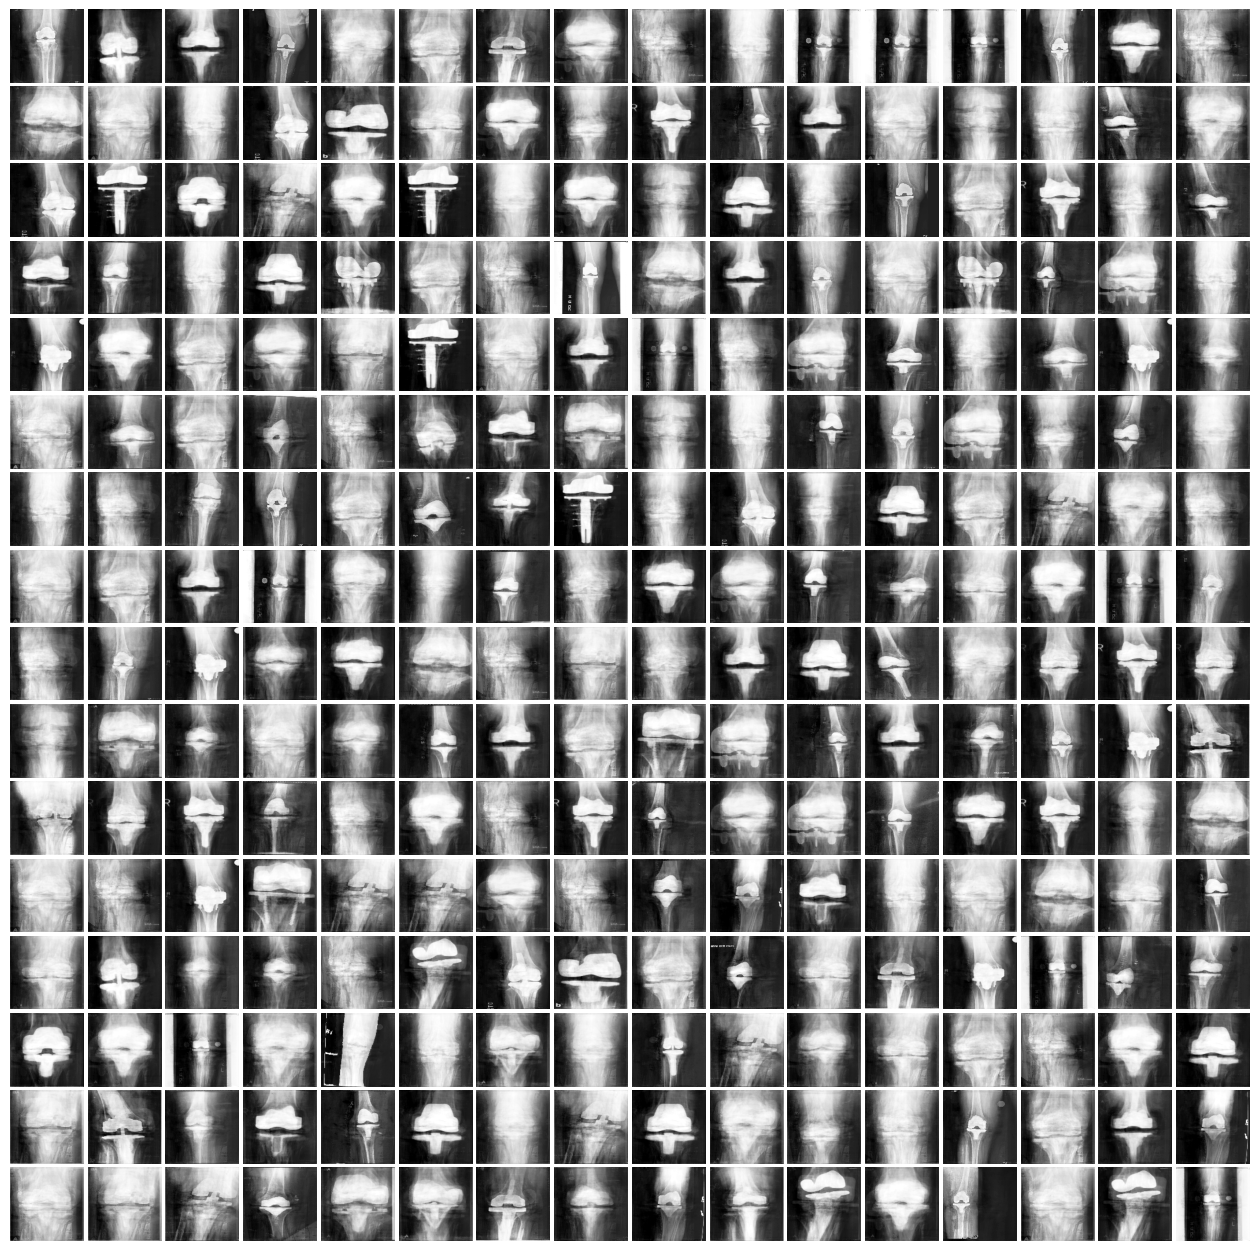

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(16, 16)
gs.update(wspace=0.05, hspace=0.05)
samples=X_train1[0:256,:] #highDimGen
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(128,128), cmap='Greys_r')

    

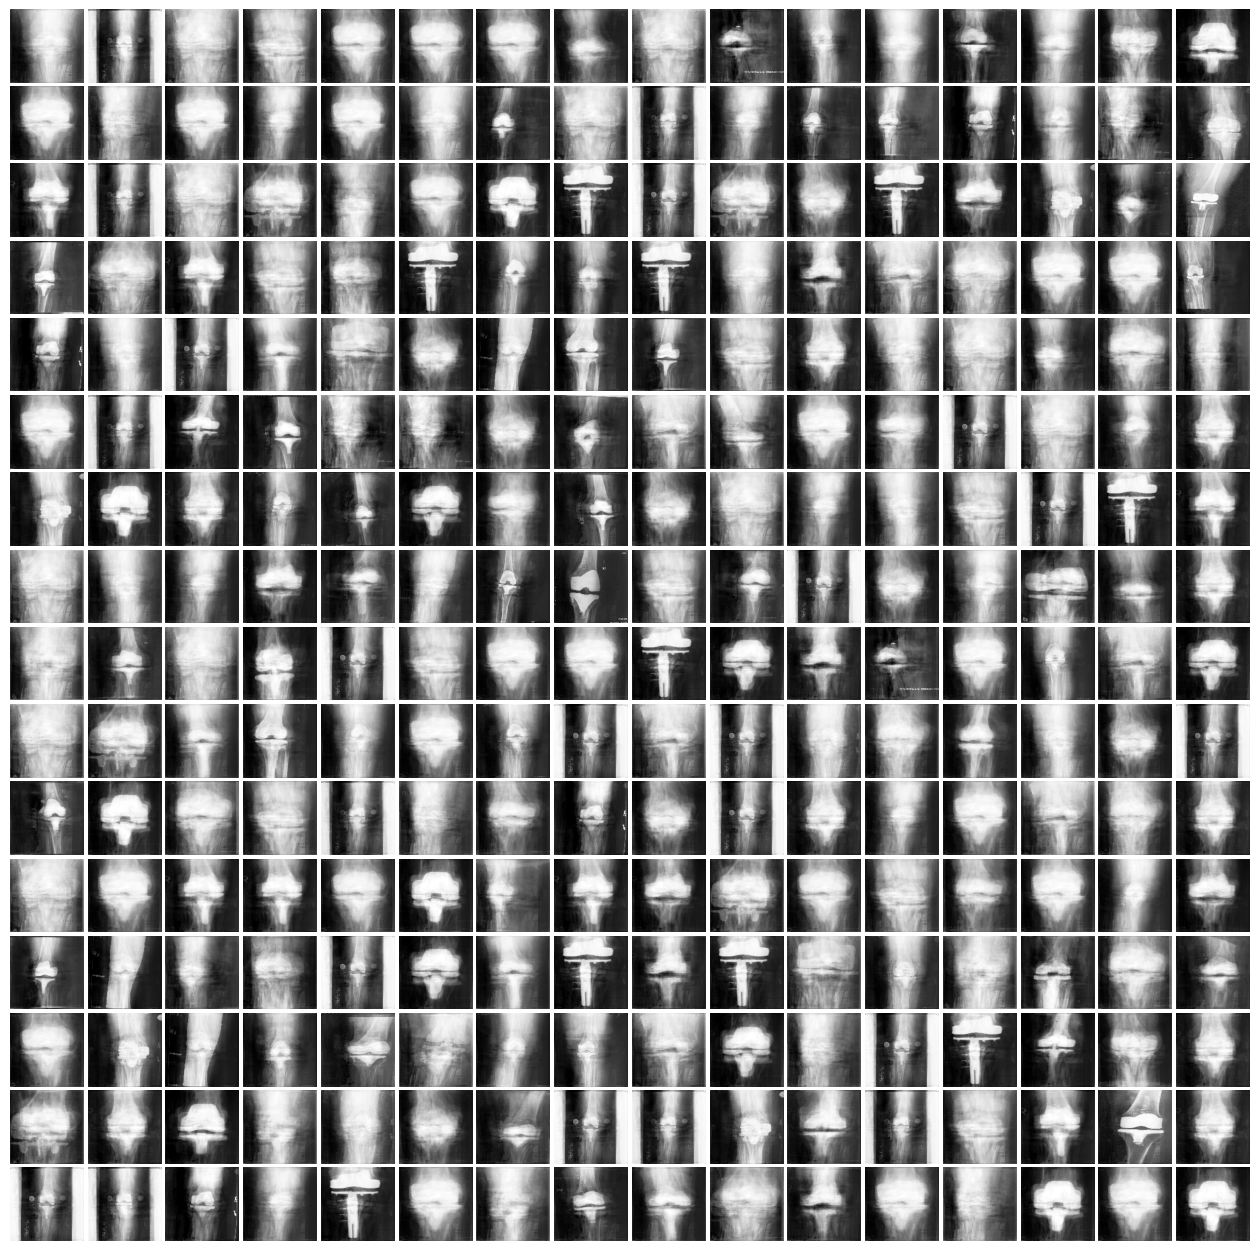

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(16, 16)
gs.update(wspace=0.05, hspace=0.05)
samples=X_train1[0:256,:] #highDimGen
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(128,128), cmap='Greys_r')

    